## Load Dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

In [3]:
# libgomp issue, must import n2 before torch
from n2 import HnswIndex

In [4]:
import sys

sys.path.insert(0, '..')

In [5]:
import os
home_dir = os.getenv('HOME')

https://dbs.uni-leipzig.de/research/projects/object_matching/benchmark_datasets_for_entity_resolution

In [6]:
import glob
import csv
from tqdm.auto import tqdm

from entity_embed.data_utils.utils import Enumerator

id_enumerator = Enumerator()
row_dict = {}
left_id_set = set()
right_id_set = set()
rows_total = 1363 + 3226
clusters_total = 1300

with tqdm(total=rows_total) as pbar:
    with open(f'{home_dir}/Downloads/Amazon-GoogleProducts/Amazon.csv', encoding="latin1") as f:
        for row in csv.DictReader(f):
            row['id'] = id_enumerator[row["id"]]
            row['name'] = row.pop('title')
            row['source'] = 'google'
            row_dict[row['id']] = row
            left_id_set.add(row['id'])
            pbar.update(1)
    
    with open(f'{home_dir}/Downloads/Amazon-GoogleProducts/GoogleProducts.csv', encoding="latin1") as f:
        for row in csv.DictReader(f):
            row['id'] = id_enumerator[row["id"]]
            row['source'] = 'amazon'
            row_dict[row['id']] = row
            right_id_set.add(row['id'])
            pbar.update(1)

In [7]:
true_pair_set = set()

with open(f'{home_dir}/Downloads/Amazon-GoogleProducts/Amzon_GoogleProducts_perfectMapping.csv') as f:
    for row in csv.DictReader(f):
        id_left = id_enumerator[row['idAmazon']]
        id_right = id_enumerator[row['idGoogleBase']]
        true_pair_set.add((id_left, id_right))

len(true_pair_set)

1300

In [8]:
from entity_embed.data_utils.utils import id_pairs_to_cluster_mapping_and_dict

cluster_mapping, cluster_dict = id_pairs_to_cluster_mapping_and_dict(true_pair_set)
len(cluster_mapping)

2404

In [9]:
len(cluster_dict)

1105

In [10]:
# TODO: deal with this difference
# from entity_embed.data_utils.utils import cluster_dict_to_id_pairs

# assert len(true_pair_set - cluster_dict_to_id_pairs(cluster_dict)) == 0

In [11]:
cluster_attr = 'cluster_id'
max_cluster_id = max(cluster_mapping.values())

for row_id, row in tqdm(row_dict.items()):
    try:
        row[cluster_attr] = cluster_mapping[row_id]
    except KeyError:
        row[cluster_attr] = max_cluster_id
        max_cluster_id += 1

In [12]:
[row_dict[row_id] for row_id in next(iter(true_pair_set))]

[{'id': 938,
  'description': 'improve your typing skills today! typing instructor deluxe has a progressive design that has been developed for over 19 years. typing instructor deluxe can provide the right lessons tests strengthening exercises practice material and typing games for your skill level. you can even build your own personal typing plan to focus on specific areas you would like to improve. if you think learning has to be all hard work and no fun think again! for beginning to advanced typists kids to adults typing instructor deluxe will motivate you to improve your typing speed and accuracy using a travel theme and exciting typing challenges.educates entertains and motivates: choose from many typing plans or build your ownnavigate easily and choose your typing materialnew! dynamic learning methodsave your results and reports to track progresslearn voice-touch typing (dictation)3 unique travel themescolorful photos and musicten exciting games300+ magazine articles',
  'manufact

## Preprocess

In [13]:
attr_list = ['name', 'description', 'manufacturer', 'price']

In [14]:
import unidecode
import itertools
from entity_embed import default_tokenizer

def clean_str(s):
    s = unidecode.unidecode(s).lower().strip()
    s_tokens = itertools.islice((s_part[:30] for s_part in default_tokenizer(s)), 0, 30)
    return ' '.join(s_tokens)[:300]

for row in tqdm(row_dict.values()):
    for attr in attr_list:
        row[attr] = clean_str(row[attr])

## Init Data Module

In [15]:
import torch
import numpy as np

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

In [16]:
alphabet = list('0123456789abcdefghijklmnopqrstuvwxyz!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ ')

In [17]:
attr_info_dict = {
    'name': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'use_mask': True,
        'max_str_len': None,  # compute
    },
    'description': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'use_mask': True,
        'max_str_len': None,  # compute
    },
    'manufacturer': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'use_mask': True,
        'max_str_len': None,  # compute
    },
    'price': {
        'field_type': "STRING",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    }
}

In [18]:
from entity_embed import AttrInfoDictParser

row_numericalizer = AttrInfoDictParser.from_dict(attr_info_dict, row_dict=row_dict)
row_numericalizer.attr_info_dict

10:44:45 INFO:For attr=name, computing actual max_str_len
10:44:45 INFO:For attr=name, using actual_max_str_len=26
10:44:45 INFO:For attr=description, computing actual max_str_len
10:44:45 INFO:actual_max_str_len=29 must be pair to enable NN pooling. Updating to 30
10:44:45 INFO:For attr=description, using actual_max_str_len=30
10:44:45 INFO:For attr=manufacturer, computing actual max_str_len
10:44:45 INFO:actual_max_str_len=15 must be pair to enable NN pooling. Updating to 16
10:44:45 INFO:For attr=manufacturer, using actual_max_str_len=16
10:44:45 INFO:For attr=price, computing actual max_str_len
10:44:45 INFO:For attr=price, using actual_max_str_len=14


{'name': NumericalizeInfo(field_type=<FieldType.MULTITOKEN: 'multitoken'>, tokenizer='entity_embed.data_utils.numericalizer.default_tokenizer', alphabet=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', ' '], max_str_len=26, vocab=None, n_channels=8, embed_dropout_p=0.2, use_attention=True, use_mask=True),
 'description': NumericalizeInfo(field_type=<FieldType.MULTITOKEN: 'multitoken'>, tokenizer='entity_embed.data_utils.numericalizer.default_tokenizer', alphabet=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',',

In [19]:
from entity_embed import LinkageDataModule

train_cluster_len = 200
valid_cluster_len = 200
datamodule = LinkageDataModule(
    row_dict=row_dict,
    cluster_attr=cluster_attr,
    row_numericalizer=row_numericalizer,
    batch_size=50,
    row_batch_size=16,
    train_cluster_len=train_cluster_len,
    valid_cluster_len=valid_cluster_len,
    test_cluster_len=clusters_total - valid_cluster_len - train_cluster_len,
    only_plural_clusters=True,
    left_id_set=left_id_set,
    right_id_set=right_id_set,
    random_seed=random_seed
)

## Training

In [20]:
from entity_embed import LinkageEmbed

ann_k = 100
model = LinkageEmbed(
    datamodule,
    ann_k=ann_k,
)

In [21]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

max_epochs = 100
early_stop_callback = EarlyStopping(
   monitor='valid_recall_at_0.3',
   min_delta=0.00,
   patience=20,
   verbose=True,
   mode='max'
)
tb_log_dir = 'tb_logs'
tb_name = 'amzn-googl'
trainer = pl.Trainer(
    gpus=1,
    max_epochs=max_epochs,
    check_val_every_n_epoch=1,
    callbacks=[early_stop_callback],
    logger=TensorBoardLogger(tb_log_dir, name=tb_name)
)

10:44:46 INFO:GPU available: True, used: True
10:44:46 INFO:TPU available: None, using: 0 TPU cores
10:44:46 INFO:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [22]:
trainer.fit(model, datamodule)

10:44:46 INFO:Train pair count: 292
10:44:46 INFO:Valid pair count: 265
10:44:46 INFO:Test pair count: 998
10:44:48 INFO:
  | Name        | Type       | Params
-------------------------------------------
0 | blocker_net | BlockerNet | 3.3 M 
1 | losser      | SupConLoss | 0     
-------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params


1

In [23]:
model.blocker_net.get_signature_weights()

{'name': 0.3085906207561493,
 'description': 0.24385231733322144,
 'manufacturer': 0.23534926772117615,
 'price': 0.21220777928829193}

In [24]:
from entity_embed import validate_best

validate_best(trainer)

{'valid_f1_at_0.3': 0.18152218152218152,
 'valid_f1_at_0.5': 0.6252100840336134,
 'valid_f1_at_0.7': 0.5623188405797102,
 'valid_f1_at_0.9': 0.04291845493562232,
 'valid_pair_entity_ratio_at_0.3': 5.207943925233645,
 'valid_pair_entity_ratio_at_0.5': 0.8574766355140186,
 'valid_pair_entity_ratio_at_0.7': 0.2733644859813084,
 'valid_pair_entity_ratio_at_0.9': 0.011682242990654205,
 'valid_precision_at_0.3': 0.10004486316733961,
 'valid_precision_at_0.5': 0.5068119891008175,
 'valid_precision_at_0.7': 0.8290598290598291,
 'valid_precision_at_0.9': 1.0,
 'valid_recall_at_0.3': 0.9780701754385965,
 'valid_recall_at_0.5': 0.8157894736842105,
 'valid_recall_at_0.7': 0.42543859649122806,
 'valid_recall_at_0.9': 0.021929824561403508}

## Testing

In [25]:
trainer.test(ckpt_path='best', verbose=False)

10:45:52 INFO:Train pair count: 292
10:45:52 INFO:Valid pair count: 265
10:45:52 INFO:Test pair count: 998


[{'test_f1_at_0.3': 0.07250755287009063,
  'test_f1_at_0.5': 0.4309290953545232,
  'test_f1_at_0.7': 0.5236414961185604,
  'test_f1_at_0.9': 0.05523590333716916,
  'test_pair_entity_ratio_at_0.3': 14.092327698309493,
  'test_pair_entity_ratio_at_0.5': 1.5851755526657998,
  'test_pair_entity_ratio_at_0.7': 0.3790637191157347,
  'test_pair_entity_ratio_at_0.9': 0.022756827048114433,
  'test_precision_at_0.3': 0.037648795792193414,
  'test_precision_at_0.5': 0.2891714520098441,
  'test_precision_at_0.7': 0.6363636363636364,
  'test_precision_at_0.9': 0.6857142857142857,
  'test_recall_at_0.3': 0.9784172661870504,
  'test_recall_at_0.5': 0.8453237410071942,
  'test_recall_at_0.7': 0.4448441247002398,
  'test_recall_at_0.9': 0.02877697841726619}]

## Testing manually 

In [26]:
# Only call this if test above wasn't run
# datamodule.setup(stage='test')

In [27]:
test_row_dict = datamodule.test_row_dict
test_left_vector_dict, test_right_vector_dict = model.predict(
    row_dict=test_row_dict,
    left_id_set=left_id_set,
    right_id_set=right_id_set,
    batch_size=16
)

In [28]:
embedding_size = model.blocker_net.embedding_size
test_true_pair_set = datamodule.test_true_pair_set

In [29]:
assert (len(test_left_vector_dict) + len(test_right_vector_dict)) == len(test_row_dict)

In [30]:
%%time

from entity_embed import ANNLinkageIndex

ann_index = ANNLinkageIndex(embedding_size=embedding_size)
ann_index.insert_vector_dict(left_vector_dict=test_left_vector_dict, right_vector_dict=test_right_vector_dict)
ann_index.build()

CPU times: user 372 ms, sys: 5.8 ms, total: 378 ms
Wall time: 62.3 ms


In [31]:
%%time

sim_threshold = 0.3
found_pair_set = ann_index.search_pairs(
    k=ann_k,
    sim_threshold=sim_threshold,
    left_vector_dict=test_left_vector_dict,
    right_vector_dict=test_right_vector_dict,
)

CPU times: user 606 ms, sys: 3.26 ms, total: 609 ms
Wall time: 84 ms


In [32]:
from entity_embed.evaluation import pair_entity_ratio

pair_entity_ratio(len(found_pair_set), len(test_row_dict))

14.092327698309493

In [33]:
from entity_embed.evaluation import precision_and_recall

precision_and_recall(found_pair_set, test_true_pair_set)

(0.037648795792193414, 0.9784172661870504)

In [34]:
false_positives = list(found_pair_set - test_true_pair_set)
len(false_positives)

20858

In [35]:
false_negatives = list(test_true_pair_set - found_pair_set)
len(false_negatives)

18

In [36]:
cos_similarity = lambda a, b: np.dot(a, b)

In [37]:
for (id_left, id_right) in false_negatives[:10]:
    display(
        (
            cos_similarity(test_left_vector_dict[id_left], test_right_vector_dict[id_right]),
            row_dict[id_left], row_dict[id_right]
        )
    )

(0.2869596,
 {'id': 799,
  'description': '- marketing information : hp digital sending software 4 . 0 improves core business processes . digital sending streamlines critical business document handling and integrates with existing it infrastructures to',
  'manufacturer': 'hewlett packard ( consumables )',
  'price': '630 . 36',
  'name': 'hp dss software - ( v . 4 . 0 ) - complete package ( t1936aa ua0 )',
  'source': 'google',
  'cluster_id': 799},
 {'id': 3955,
  'name': 'hp t1936aa uao digital sending software 4 . 0 ( 10 device license )',
  'description': 'hp dss 4 . 0 is the entry - level member of a family of server - based software products that enables paper documents to be incorporated into electronic business',
  'manufacturer': 'hp',
  'price': '369 . 99',
  'source': 'amazon',
  'cluster_id': 799})

(0.2263673,
 {'id': 125,
  'description': '',
  'manufacturer': 'compaq computer',
  'price': '0',
  'name': 'compaq comp . rapid deployment pk - flexible lic kit ( 302127 - b21 )',
  'source': 'google',
  'cluster_id': 125},
 {'id': 3231,
  'name': 'hewlett packard 302127 - b21 prol essentials rdp v1 . x 1u flex lic min qty 5',
  'description': 'prol essentials rdp v1 . x 1u flex lic min qty 5',
  'manufacturer': '',
  'price': '119 . 73',
  'source': 'amazon',
  'cluster_id': 125})

(0.29959604,
 {'id': 915,
  'description': 'allegro 2005 provides professional - grade instrument sounds terrific marching percussion and more options for getting music on the page . human playback adds dynamics and phrasing to your music',
  'manufacturer': 'makemusic !',
  'price': '199 . 99',
  'name': 'allegro 2005',
  'source': 'google',
  'cluster_id': 915},
 {'id': 1521,
  'name': 'emedia finale allegro',
  'description': 'pc : windows 98 / 2000 / me / xp cd - rom drive 800x600 minimum monitor resolution 256 mb ram recommended ( 128 mb may be sufficient in older',
  'manufacturer': '',
  'price': '169 . 99',
  'source': 'amazon',
  'cluster_id': 915})

(0.16526748,
 {'id': 918,
  'description': 'mobi 70008 recam 4 . 6 camera monitoring and notification software surveillance software captures and analyzes images for advanced monitoring and recording of home or office ; program performs simultaneous',
  'manufacturer': 'mobi technologies inc .',
  'price': '129',
  'name': 'recam remote monitoring software',
  'source': 'google',
  'cluster_id': 918},
 {'id': 3921,
  'name': 'mobi - cam 70008 monitoring and notification software',
  'description': 'easily set - up and monitor your home or business observation system from anywhere notification of alarm and viewing via e - mail internet or cell phone multiple camera support',
  'manufacturer': 'mobi - cam',
  'price': '89 . 69',
  'source': 'amazon',
  'cluster_id': 918})

(0.0031865877,
 {'id': 845,
  'description': "iplaymusic ' s beginner guitar lessons is the first guitar learning program optimized for the mac and video ipod . the software takes advantage of ilife applications resident on today",
  'manufacturer': 'iplaymusic',
  'price': '49 . 99',
  'name': 'iplaymusic beginner guitar lessons for the mac and ipod',
  'source': 'google',
  'cluster_id': 845},
 {'id': 2324,
  'name': "wingnuts 2 : raina ' s revenge",
  'description': 'system requirements : mac os x 10 . 4 + g4 / g5 / intel 800 + mhz cpu 512 mb ram 32 mb video card 950 mb hard drive',
  'manufacturer': '',
  'price': '28 . 99',
  'source': 'amazon',
  'cluster_id': 845})

(0.22637223,
 {'id': 799,
  'description': '- marketing information : hp digital sending software 4 . 0 improves core business processes . digital sending streamlines critical business document handling and integrates with existing it infrastructures to',
  'manufacturer': 'hewlett packard ( consumables )',
  'price': '630 . 36',
  'name': 'hp dss software - ( v . 4 . 0 ) - complete package ( t1936aa ua0 )',
  'source': 'google',
  'cluster_id': 799},
 {'id': 2167,
  'name': 'hewlett packard t1936aa ua0 - hp digital sending software 4 . 0 - complete product - document management - 1 device ( s ) - complete product - standard -',
  'description': 'hewlett packard t1936aa ua0 : the hp mfp digital sending software ( hp dss ) is a software application that enables an hp multifunction peripheral ( mfp ) to send',
  'manufacturer': '',
  'price': '342 . 97',
  'source': 'amazon',
  'cluster_id': 799})

(0.29755285,
 {'id': 1154,
  'description': 'finale 2006 provides you with robust tools unlimited options and total control . with more power and speed than ever before finale offers endless possibilities for composing arranging hearing and',
  'manufacturer': 'emedia',
  'price': '600',
  'name': 'finale 2006 ( pc & mac )',
  'source': 'google',
  'cluster_id': 1154},
 {'id': 3485,
  'name': 'make finale 2006 software music production software',
  'description': 'finale 2006 - professional notation and score publishing software for mac and windows for the professional composer or music publisher producing and outputting music scores and instrumental parts finale 2006',
  'manufacturer': '',
  'price': '424 . 95',
  'source': 'amazon',
  'cluster_id': 1154})

(0.26200733,
 {'id': 960,
  'description': '',
  'manufacturer': 'emedia',
  'price': '350',
  'name': 'make music finale 2008 academic',
  'source': 'google',
  'cluster_id': 960},
 {'id': 3659,
  'name': 'make finale 2007 software - educational discount music production software',
  'description': 'finale 2007 - professional notation and score publishing software for mac os x and windows 2000 / xp - educational discount for the professional composer or music publisher producing and',
  'manufacturer': '',
  'price': '289 . 95',
  'source': 'amazon',
  'cluster_id': 960})

(0.25783998,
 {'id': 822,
  'description': 'sharks 2 . 0 ( win 95 98 me 2000 xp )',
  'manufacturer': 'e b c marketing',
  'price': '19 . 99',
  'name': 'sharks 2 . 0 ( pc & mac )',
  'source': 'google',
  'cluster_id': 822},
 {'id': 3972,
  'name': 'encore software 10282 - sharks 2 . 0 ( win 95 98 me 2000 xp / mac 10 . 1 or higher )',
  'description': 'encore software 10282 : only the developers of the 1 best - selling marine aquarium can bring the ultra - realistic experience of sharks : terrors of the deep .',
  'manufacturer': '',
  'price': '18 . 97',
  'source': 'amazon',
  'cluster_id': 822})

(0.28395024,
 {'id': 747,
  'description': 'lego star wars ii sets players loose in the original three chapters of the star wars saga -- making this the true sequel our fans have been clamoring for .',
  'manufacturer': 'feral interactive',
  'price': '39 . 99',
  'name': 'lego star wars ii : the original trilogy for mac',
  'source': 'google',
  'cluster_id': 747},
 {'id': 1716,
  'name': 'aspyr lego star wars ii',
  'description': 'system requirements mac os x v10 . 4 or later 1 . 6ghz powerpc or intel processor 512mb ram 64mb vram 3gb free hard - disk space mouse and keyboard',
  'manufacturer': '',
  'price': '44 . 95',
  'source': 'amazon',
  'cluster_id': 747})

## t-sne visualization

In [38]:
vis_sample_size = 10

In [39]:
from entity_embed.data_utils.utils import row_dict_to_cluster_dict

test_vector_dict = {**test_left_vector_dict, **test_right_vector_dict}
test_cluster_dict = row_dict_to_cluster_dict(test_row_dict, cluster_attr)
vis_cluster_dict = dict(sorted(test_cluster_dict.items(), key=lambda x: len(x[1]), reverse=True)[:vis_sample_size])

In [40]:
vis_x = np.stack([test_vector_dict[id_] for cluster in vis_cluster_dict.values() for id_ in cluster])
vis_y = np.array([cluster_id for cluster_id, cluster in vis_cluster_dict.items() for __ in cluster])

In [41]:
from sklearn.manifold import TSNE

tnse = TSNE(metric='cosine', perplexity=10, random_state=random_seed)
tsne_results = tnse.fit_transform(vis_x)

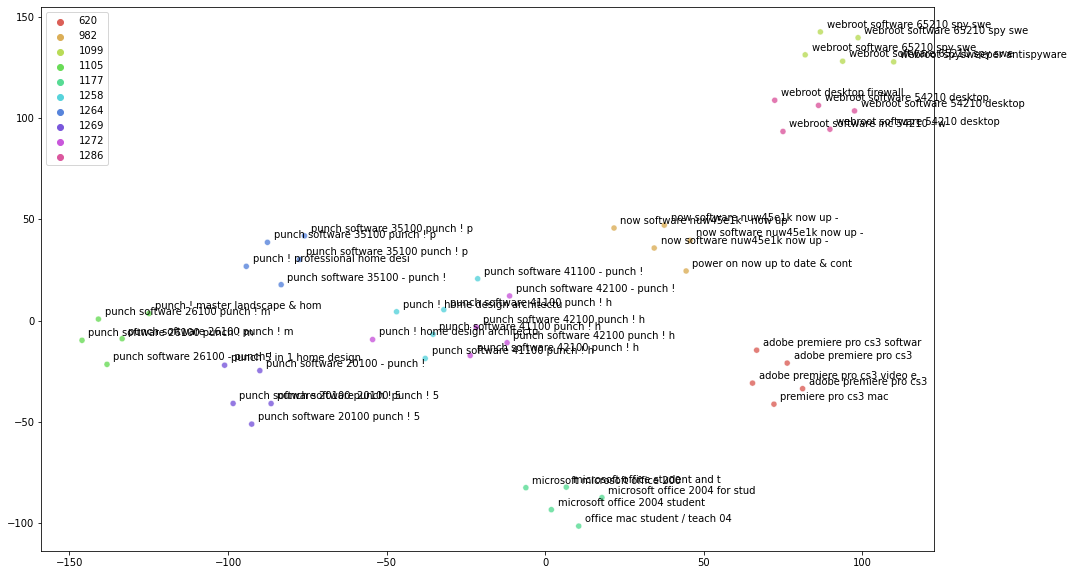

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x=tsne_results[:,0],
    y=tsne_results[:,1],
    hue=vis_y,
    palette=sns.color_palette("hls", len(vis_cluster_dict.keys())),
    legend="full",
    alpha=0.8
)
for id_, (x, y) in zip(itertools.chain.from_iterable(vis_cluster_dict.values()), tsne_results):
    # text = id_
    text = test_row_dict[id_]['name'][:30]
    ax.text(x + 2, y + 2, text)